Simple clustering of MNIST dataset using normalized compression distance

# Open data

In [1]:
from sklearn import datasets

In [2]:
digits = datasets.load_digits(n_class=10)
data = digits.data
label = digits.target
classes = digits.target_names
k = len(classes)

# Compute pairwise distance

In [3]:
from sklearn.metrics import pairwise_distances
from distance import ncd
import numpy as np

In [98]:
distances = pairwise_distances(data, metric = ncd, n_jobs = 15)
np.fill_diagonal(distances, 0) # As compression can create non zero distance

# Visualization distance

Display mean distance between labels

In [99]:
import matplotlib.pyplot as plt

In [100]:
average = np.zeros((k, k))
for i in range(k):
    for j in range(k):
        average[i, j] = distances[label == i][:, label == j].mean()
average /= average.max()

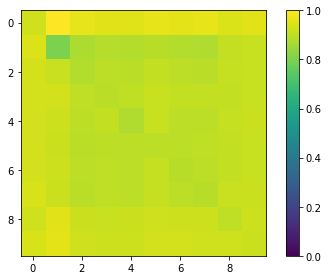

In [101]:
plt.figure()
plt.imshow(average, interpolation='nearest', vmin=0)
plt.colorbar()
plt.tight_layout()

# Clustering

In [51]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

Cluster using agglomerative based on euclidean distance

In [71]:
kmeans = KMeans(k).fit_predict(data)

Cluster using agglomerative algo on ncb distance

In [79]:
agglo = AgglomerativeClustering(k, affinity = 'precomputed', linkage = 'complete').fit_predict(distances)

# Evaluation

In [80]:
from sklearn.metrics import silhouette_score, adjusted_rand_score

### Silhouette score

Compute silhouette score using ncd

In [81]:
print("Silhouette score for perfect clustering: {:.2f}".format(silhouette_score(distances, label, metric = 'precomputed')))
print("Silhouette score for kmeans: {:.2f}".format(silhouette_score(distances, kmeans, metric = 'precomputed')))
print("Silhouette score for agglomerative: {:.2f}".format(silhouette_score(distances, agglo, metric = 'precomputed')))

Silhouette score for perfect clustering: -0.01
Silhouette score for kmeans: -0.01
Silhouette score for agglomerative: -0.00


Compute silhouette using euclidean distance

In [82]:
print("Silhouette score for perfect clustering: {:.2f}".format(silhouette_score(data, label)))
print("Silhouette score for kmeans: {:.2f}".format(silhouette_score(data, kmeans)))
print("Silhouette score for agglomerative: {:.2f}".format(silhouette_score(data, agglo)))

Silhouette score for perfect clustering: 0.16
Silhouette score for kmeans: 0.18
Silhouette score for agglomerative: -0.07


### Adjusted Score

In [83]:
print("Adjusted Rand Index for kmeans: {:.2f}".format(adjusted_rand_score(label, kmeans)))
print("Adjusted Rand Index for agglomerative: {:.2f}".format(adjusted_rand_score(label, agglo)))

Adjusted Rand Index for kmeans: 0.67
Adjusted Rand Index for agglomerative: 0.02
